# Problem Statement: To find Fraudulent Credit Card Transactions

# Machine Learning Model (Code)

## Access Data

In [1]:
#Importing required libraries
import numpy as np 
import pandas as pd 
import os
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
#Importing Dataset
df = pd.read_csv("D:/Portfolio/credit_card_transactions-ibm_v2.csv") 
#loading the dataset into a variable called df which represents a DataFrame object
df.head() #checking the first 5 rows of the DataFrame

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [3]:
#Checking dimensions of the DataFrame which returns a tuple that represents the number of rows and columns in the DataFrame
df.shape 

(24386900, 15)

## Data Pre-Processing

In [4]:
#Retaining columns that are relevant to fraud detection and dropping the others
df = df.drop(['Merchant City', 'Merchant State', 'MCC', 'Errors?'], axis=1)

In [5]:
#Decision Column- converting the target column to a boolean response
df['Is Fraud?'] = df['Is Fraud?'].replace({'Yes': 1, 'No': 0})

In [6]:
#Creating a random subset of 4,000,000 rows to save computation power and get expected results
n = 4000000
idx = np.random.choice(df.index, size=n, replace=False)
df_subset = df

In [7]:
#Checking dimensions of the DataFrame after dropping irrelevant columns
df_subset.shape

(24386900, 11)

In [8]:
#Checking the data types of the columns in the DataFrame subset
df_subset.dtypes

User               int64
Card               int64
Year               int64
Month              int64
Day                int64
Time              object
Amount            object
Use Chip          object
Merchant Name      int64
Zip              float64
Is Fraud?          int64
dtype: object

In [9]:
#Data Cleaning and transformation
df_subset['Zip'] = df_subset['Zip'].fillna(0) #filling null values of zip code with zero
df_subset['Amount'] = df_subset['Amount'].apply(lambda value: float(value.split("$")[1])) 
#converting amount column from string value to a float
df_subset['Hour'] = df_subset['Time'].apply(lambda value: int(value.split(":")[0])) 
#extracting the hour portion from the Time column converting it to an integer
df_subset['Minutes'] = df_subset['Time'].apply(lambda value: int(value.split(":")[1])) 
#extracting the minutes portion from the Time column converting it to an integer
df_subset.drop(['Time'], axis=1, inplace=True) #dropping the Time column
df_subset['Merchant Name'] = df_subset['Merchant Name'].astype("object") 
#converting Merchant Name column to object datatype
df_subset['Card'] = df_subset['Card'].astype("object") #converting Card column to object datatype
df_subset['Use Chip'] = df_subset['Use Chip'].astype("object") #converting Use Chip column to object datatype
df_subset['Zip'] = df_subset['Zip'].astype("object") #converting Zip column to object datatype

In [10]:
#Formatting the data
for col in df_subset.columns: #Converting null values to empty strings to improve the quality of data
    col_type = df_subset[col].dtype
    if col_type == 'object':
        df_subset[col] = df_subset[col].fillna("")

In [11]:
#Checking Datatypes after Data Pre-Processing
df_subset.dtypes

User               int64
Card               int64
Year               int64
Month              int64
Day                int64
Amount           float64
Use Chip          object
Merchant Name      int64
Zip              float64
Is Fraud?          int64
Hour               int64
Minutes            int64
dtype: object

In [12]:
#Checking the dimensions of DataFrame after Data Pre-Processing
df_subset.shape

(24386900, 12)

## Exploratory Data Analysis(EDA)

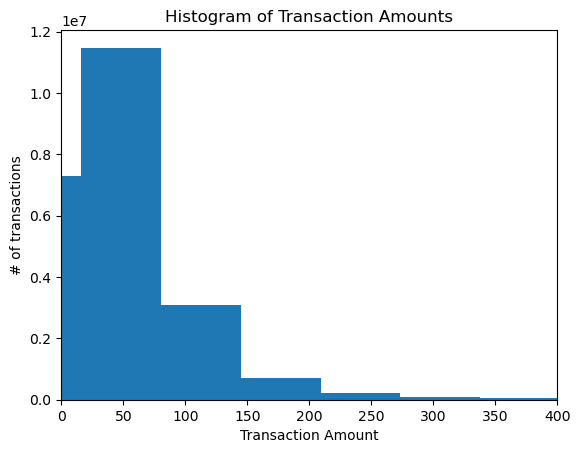

In [13]:
#Histogram of transactions
plt.hist(df_subset['Amount'], bins=200)
plt.xlabel('Transaction Amount')
plt.xlim(0, 400)  # set the lower and upper bounds of the x-axis
plt.ylabel('# of transactions')
plt.title('Histogram of Transaction Amounts')
plt.show()

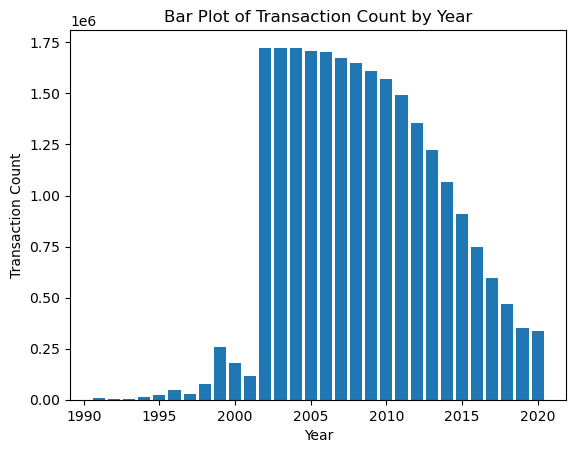

In [14]:
#Transaction count per year
plt.bar(df_subset['Year'].unique(), df_subset['Year'].value_counts())
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.title('Bar Plot of Transaction Count by Year')
plt.show()

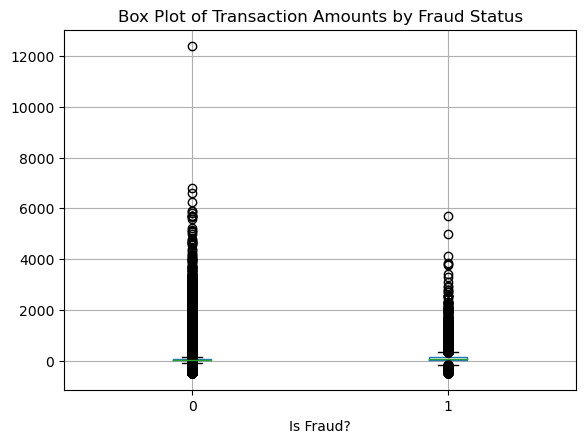

In [15]:
#Transaction amount by fraud
df_subset['Amount'] = pd.to_numeric(df_subset['Amount'], errors='coerce')
df_subset.boxplot(column='Amount', by='Is Fraud?')
plt.title('Box Plot of Transaction Amounts by Fraud Status')
plt.suptitle('')
plt.show()

In [16]:
#The above box plot shows that most of the fraudulent transactions are concentrated to lower amount.

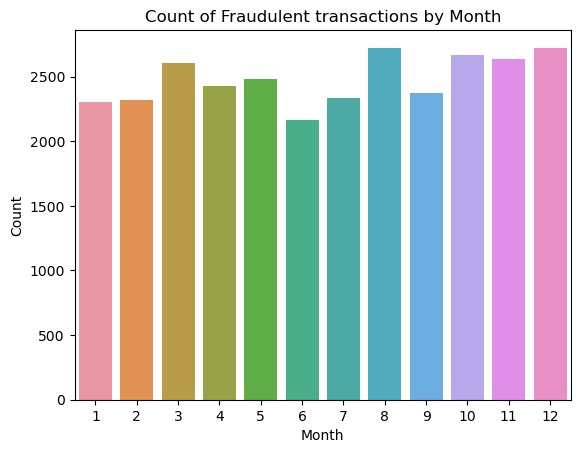

In [17]:
#Count of Fraudulent transactions by Month
fraud_by_month = df_subset[df_subset['Is Fraud?'] == 1].groupby('Month')['Is Fraud?'].count()
sns.barplot(x=fraud_by_month.index, y=fraud_by_month.values)
plt.title('Count of Fraudulent transactions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

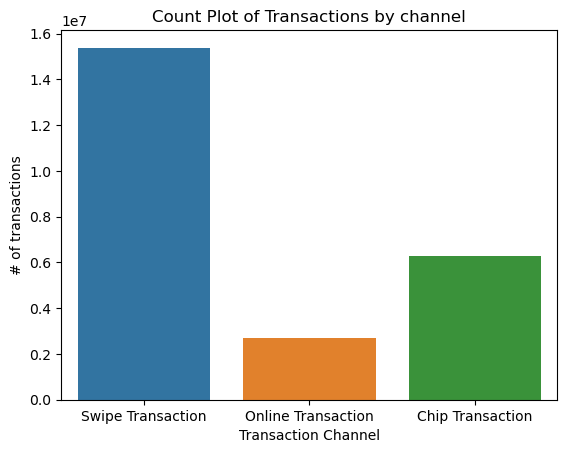

In [18]:
#Plot for chip usage to check which channel has most amount of fraudulent transactions
sns.countplot(x='Use Chip', data=df_subset)
plt.xlabel('Transaction Channel')
plt.ylabel('# of transactions')
plt.title('Count Plot of Transactions by channel')
plt.show()

In [19]:
#From the above plot we can see that Swipe Transaction channel has the maximum number of transactions

## Feature selection

In [20]:
#Using the "Is Fraud" column as our target variable 
#to determine whether a given transaction is fraudulent or not
y = df_subset['Is Fraud?'] #assigning output variable
X = df_subset.drop(['Is Fraud?'], axis=1) #assigning input variable

In [21]:
#Checking the dimensions of the input variable
X.shape

(24386900, 11)

In [22]:
#Checking the data type of the input variable
X.dtypes

User               int64
Card               int64
Year               int64
Month              int64
Day                int64
Amount           float64
Use Chip          object
Merchant Name      int64
Zip              float64
Hour               int64
Minutes            int64
dtype: object

## Data Preparation

In [23]:
#Encoding the 'Use Chip' column
le = LabelEncoder()
X['Use Chip'] = le.fit_transform(X['Use Chip']) 
#Encoding the mixed datatype of transaction category to numerical values using label encoder

In [24]:
#Scaling the input variables
sc = StandardScaler()
X = sc.fit_transform(X) 
#Scaling to ensure that each input has equal weightage during training and prediction phase

In [25]:
#Splitting the data into training(70%) and testing sets(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
#Initially started splitting train and test data as 80% and 20% respectively 
#but because fradulent transactions are way less than original transactions, 
#I have increased the percentage to 70% and 30%.

## Model Selection

In [27]:
#Defining the model architecture
model = Sequential() 
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1])) #input layer
model.add(Dense(units=32, activation='relu')) #hidden layer
model.add(Dense(units=1, activation='sigmoid')) #output layer
print(model) 
#The choice of activation function is made based on the assumption that in a transaction fraud,
#we need the value between zero and one and any negative value is equal to 
#transaction being not fraud and can be moved to zero.

In [28]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
#Since we are using binary classification,our compilation steps are based on 
#binary_crossentropy as a loss function to get desired binary output.

## Training the Model

In [29]:
#Training the model with early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=5, batch_size=1024, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])
#Using a callback to stop if validation losses do not improve after certain epochs

Epoch 1/5
16671/16671 [==============================] - 106s 6ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0067 - val_accuracy: 0.9988
Epoch 2/5
16671/16671 [==============================] - 94s 6ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.0064 - val_accuracy: 0.9988
Epoch 3/5
16671/16671 [==============================] - 94s 6ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.0062 - val_accuracy: 0.9988
Epoch 4/5
16671/16671 [==============================] - 95s 6ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 5/5
16671/16671 [==============================] - 98s 6ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9987


## Model Evaluation

In [30]:
#Evaluating the trained neural network model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

228628/228628 [==============================] - 466s 2ms/step


In [31]:
#Confusion matrix and classification report
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_classes)) 
#summarizing the predictions made by the model compared to actual true labels.
print('Classification report:')
print(classification_report(y_test, y_pred_classes)) 
#detailed summary of various evaluation metrics for each class.

Confusion matrix:
[[7306328     833]
 [   8328     581]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307161
           1       0.41      0.07      0.11      8909

    accuracy                           1.00   7316070
   macro avg       0.70      0.53      0.56   7316070
weighted avg       1.00      1.00      1.00   7316070



In [32]:
#Calculating the evaluation metrics for the model
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred_classes, average='binary', pos_label=1)
f1 = f1_score(y_test, y_pred_classes, average='binary', pos_label=1)

In [33]:
#Printing the evaluation metrics to evaluate model's performance
print('Accuracy:', accuracy) 
#ratio of correctly predicted instances to the total number of instances
print('Precision:', precision) 
#ratio of correctly predicted positive instances to total instances predicted as positive
print('Recall:', recall) 
#proportion of correctly predicted positive instances to total actual positive instances
print('F1 Score:', f1) 
#harmonic mean of precision and recall

Accuracy: 0.9987478249934733
Precision: 0.41089108910891087
Recall: 0.06521495117297116
F1 Score: 0.11256417708030612


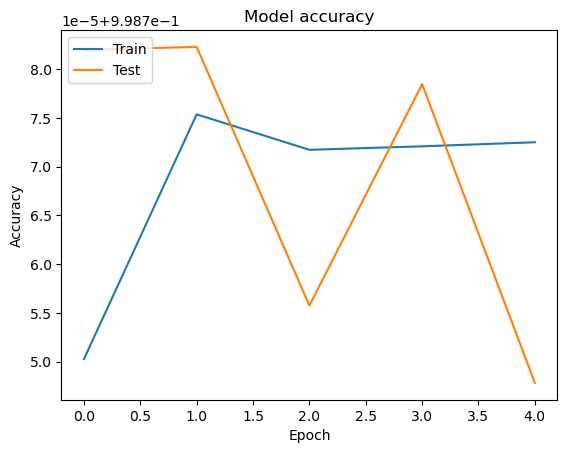

In [34]:
#Plotting the Learning Curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
#The performance on both the training and testing sets levels off which implies that 
#additional training data may not provide significant improvement.
#The Artifical Neural Network model achieved an accuracy of 99.87% on the test dataset 
#indicating its a good fit. 